In [4]:
import numpy as np
import pandas as pd

metasamples = pd.read_excel('../Metadata4.xlsx')

# Keep only samples that are tumor-normal pair and labeled as included
df = metasamples.loc[(metasamples['INCLUDED'] == "Y")
                     & (metasamples['TUMOR_ONLY'] == "No")
                     & (metasamples['SAMPLE_TYPE'] != "gDNA"), 
                     ['PATIENT_ID', 'SAMPLE_ID']]
metasamples.index = metasamples['SAMPLE_ID']
meta_filtered = metasamples.reindex(df['SAMPLE_ID'].tolist())
samples = [x.strip() for x in df['SAMPLE_ID'] + '-' + df['PATIENT_ID']]
meta_filtered.index = samples

spectra_snv = pd.read_csv('../analysis/merged_maf_spectra_snvs.txt', sep='\t', index_col=0, header=0)
samples_snv = np.intersect1d(samples, spectra_snv.columns)
spectra_snv = spectra_snv.loc[:,samples_snv]
spectra_snv = spectra_snv.dropna()

spectra_indels = pd.read_csv('../analysis/merged_maf_spectra_indels.txt', sep='\t', index_col=0, header=0)
samples_indels = np.intersect1d(samples, spectra_indels.columns)
spectra_indels = spectra_indels.loc[:,samples_indels]
spectra_indels = spectra_snv.dropna()

In [5]:
meta_filtered.head()

,PATIENT_ID,SAMPLE_ID,SAMPLE_TYPE,GENDER,INCLUDED,DAYS_AFTER_TREATMENT,AGE_DX,VAR1,VAR2,VAR3,...,VAR5,VAR6,VAR7,LANE,FASTA1,FASTA2,ROUND,MSI_ISH,MSI_SCORE,TUMOR_ONLY
1123_3_cfDNA-VHIO_01,VHIO_01,1123_3_cfDNA,cfDNA,XX,Y,224.0,55.0,BEFORE,F,PD,...,2L,1L_2L,triplete,1.0,s3://scitron/exomes/1123_1.fastq.gz,s3://scitron/exomes/1123_2.fastq.gz,FIRST,MSS,8.32,No
1261_2_cfDNA-VHIO_01,VHIO_01,1261_2_cfDNA,cfDNA,XX,Y,310.0,55.0,NaN,F,PD,...,2L,1L_2L,triplete,1.0,s3://scitron/exomes/1261_1.fastq.gz,s3://scitron/exomes/1261_2.fastq.gz,FIRST,MSS,13.29,No
B19_0970__VH_17_B_022863_A5__1_tumor-VHIO_01,VHIO_01,B19_0970__VH_17_B_022863_A5__1_tumor,tumor,XX,Y,266.0,55.0,AFTER,F,PD,...,2L,1L_2L,triplete,1.0,s3://scitron/exomes/B19_0970_S3_R1_001.fastq.gz,s3://scitron/exomes/B19_0970_S3_R2_001.fastq.gz,FIRST,MSS,1.95,No
1514_5_cfDNA-VHIO_02,VHIO_02,1514_5_cfDNA,cfDNA,XY,Y,336.0,57.0,NaN,F,short SD,...,2L,1L_2L,doblete,1.0,s3://scitron/exomes/1514_1.fastq.gz,s3://scitron/exomes/1514_2.fastq.gz,FOURTH,MSS,7.57,No
916_6_cfDNA-VHIO_02,VHIO_02,916_6_cfDNA,cfDNA,XY,Y,35.0,57.0,NaN,F,short SD,...,2L,1L_2L,doblete,1.0,s3://scitron/exomes/916_1.fastq.gz,s3://scitron/exomes/916_2.fastq.gz,FOURTH,MSS,6.79,No


In [6]:
meta_filtered.shape

(35, 21)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

color_map = ["red", "green", "blue", "orange", "cyan", "yellow", "orchid", 
             "saddlebrown", "darkcyan", "gray", "darkred", "darkgreen", "darkblue", 
             "antiquewhite", "bisque", "black", "slategray", "gold", "floralwhite",
             "aliceblue", "plum", "cadetblue", "coral", "olive", "khaki", "lightsalmon"]

def plot_heatmap(data, meta, title, filename):
    figsize = (16,16)
    cmap = "bwr"
    vmax = None
    vmin = None

    var1_colors = [color_map[0] if x == 'E' else color_map[1] for x in meta['VAR2']]
    var2_colors = [color_map[2] if x == 'BEFORE' else color_map[3] if x == 'AFTER' else (1,1,1) for x in meta['VAR1']]
    var3 = meta['VAR3'].copy()
    var3.loc[var3 == 'CR'] = color_map[4]
    var3.loc[var3 == 'PD'] = color_map[5]
    var3.loc[var3 == 'PR'] = color_map[6]
    var3.loc[var3 == 'long SD'] = color_map[7]
    var3.loc[var3 == 'short SD'] = color_map[8]
    var3_colors = var3.to_list()
    var7_colors = [color_map[9] if x == 'doblete' else color_map[10] for x in meta['VAR7']]

    ax = sns.clustermap(data,
                        z_score=1,
                        cmap=cmap,
                        rasterized=True,
                        yticklabels=1,
                        row_colors=[var1_colors, var2_colors, var3_colors, var7_colors],
                        vmax=vmax,
                        vmin=vmin)
    
    handles = [Patch(color=color_map[0], label='E'),
               Patch(color=color_map[1], label='F'),
               Patch(color=color_map[2], label='BEFORE'),
               Patch(color=color_map[3], label='AFTER'),
               Patch(color=color_map[4], label='CR'),
               Patch(color=color_map[5], label='PD'),
               Patch(color=color_map[6], label='PR'),
               Patch(color=color_map[7], label='long SD'),
               Patch(color=color_map[8], label='short SD'),
               Patch(color=color_map[9], label='doblete'),
               Patch(color=color_map[10], label='triplete')]
    ax.ax_heatmap.set_title(title, fontsize=18)
    ax.ax_heatmap.set_xlabel("Signatures",fontsize=16)
    ax.ax_heatmap.set_ylabel("Samples", fontsize=16)
    ax.ax_heatmap.tick_params(labelsize=10)
    ax.ax_row_dendrogram.legend(handles=handles, loc="lower left")
    ax.savefig(filename)
    
    
def plot_pca(data, colors, labels, title, filename):

    if data.shape[1] > 2:
        reduced_data = PCA(whiten=False, n_components=2).fit_transform(data)
    else:
        reduced_data = data.to_numpy()
        
    unique_colors = set(colors)
    color_values = [color_map[i] for i in unique_colors]
    colors = [color_map[i] for i in colors]

    fig, ax = plt.subplots(figsize=(12,12))
    sc = ax.scatter(reduced_data[:, 0],
                    reduced_data[:, 1], 
                    c=colors, 
                    edgecolor="none", 
                    cmap=None, 
                    s=40)

    ax.set_xlabel('PCA1', fontsize=16)
    ax.set_ylabel('PCA2', fontsize=16)
    ax.set_title(title, size=18)
    ax.legend([plt.Line2D((0, 1), (0, 0), color=x) for x in color_values],
              labels, loc="upper right", markerscale=1.0,
              ncol=1, scatterpoints=1, fontsize=16)
    fig.savefig(filename)

In [8]:
def make_plots(data, meta, name):
    
    plot_heatmap(data, 
                 meta, 
                 'Signatures_{}'.format(name), 
                 'Signatures_{}.pdf'.format(name))
    
    
    var1_colors = [0 if x == 'E' else 1 for x in meta['VAR2']]
    plot_pca(data, 
             colors=var1_colors,
             labels=['E', 'F'],
             title='Signatures {} (VAR1)'.format(name),
             filename='pca_signature_{}_var1.pdf'.format(name))

    var2_colors = [1 if x == 'BEFORE' else 2 if x == 'AFTER' else 3 for x in meta['VAR1']]
    plot_pca(data, 
             colors=var2_colors,
             labels=['BEFORE', 'AFTER', 'Na'],
             title='Signatures {} (VAR2)'.format(name),
             filename='pca_signature_{}_var2.pdf'.format(name))

    var3 = meta['VAR3'].copy()
    var3.loc[var3 == 'CR'] = 1
    var3.loc[var3 == 'PD'] = 2
    var3.loc[var3 == 'PR'] = 3
    var3.loc[var3 == 'long SD'] = 4
    var3.loc[var3 == 'short SD'] = 5
    var3_colors = var3.to_list()
    labels = ['CR', 'PD', 'PR', 'long SD', 'short SD']
    plot_pca(data, 
             colors=var3_colors,
             labels=labels,
             title='Signatures {} (VAR3)'.format(name),
             filename='pca_signature_{}_var3.pdf'.format(name))

    var7 = meta['VAR7'].copy()
    var7.loc[var7 == 'doblete'] = 1
    var7.loc[var7 == 'triplete'] = 2
    var7_colors = var7.to_list()
    labels = ['doblete', 'triplete']
    plot_pca(data, 
             colors=var7_colors,
             labels=labels,
             title='Signatures {} (VAR7)'.format(name),
             filename='pca_signature_{}_var7.pdf'.format(name))

nit=  694 K=3 	del=0.000000932


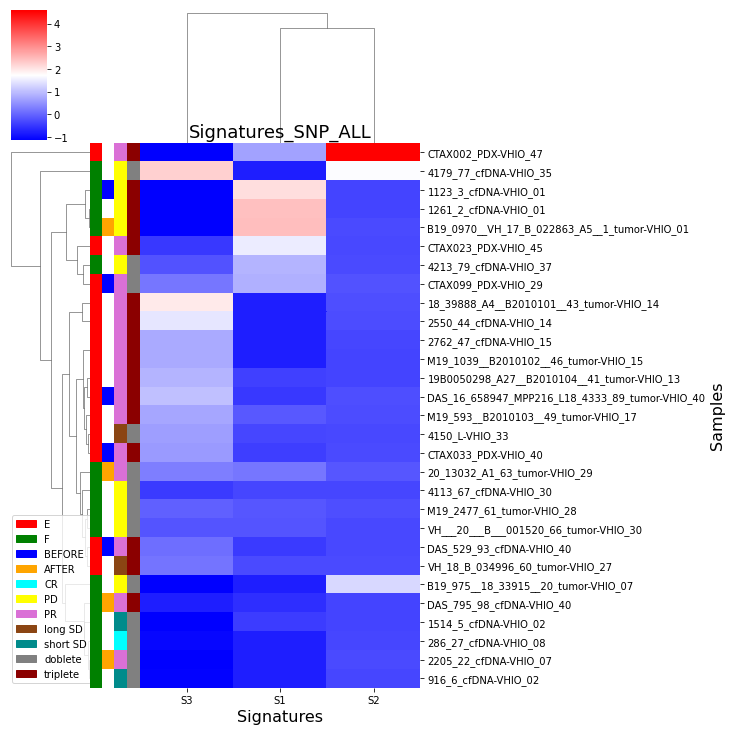

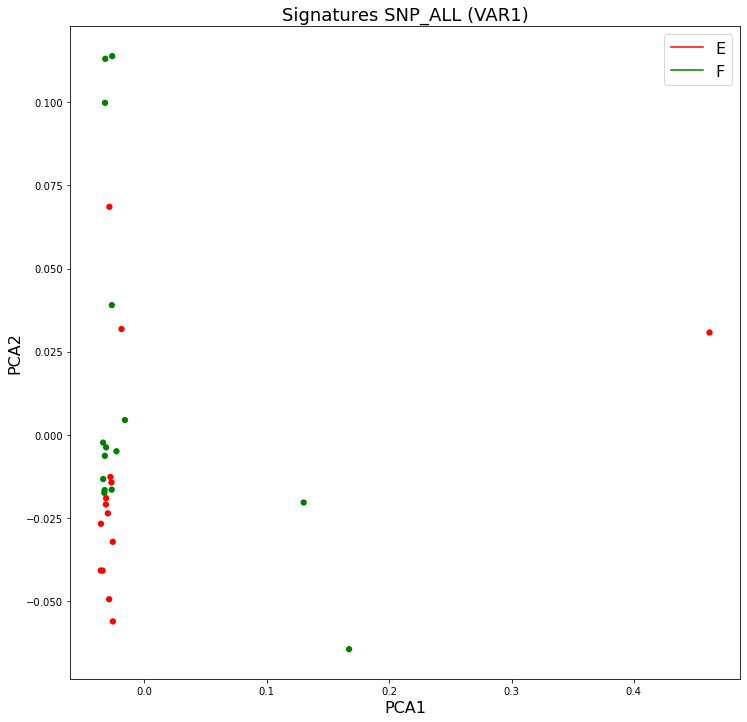

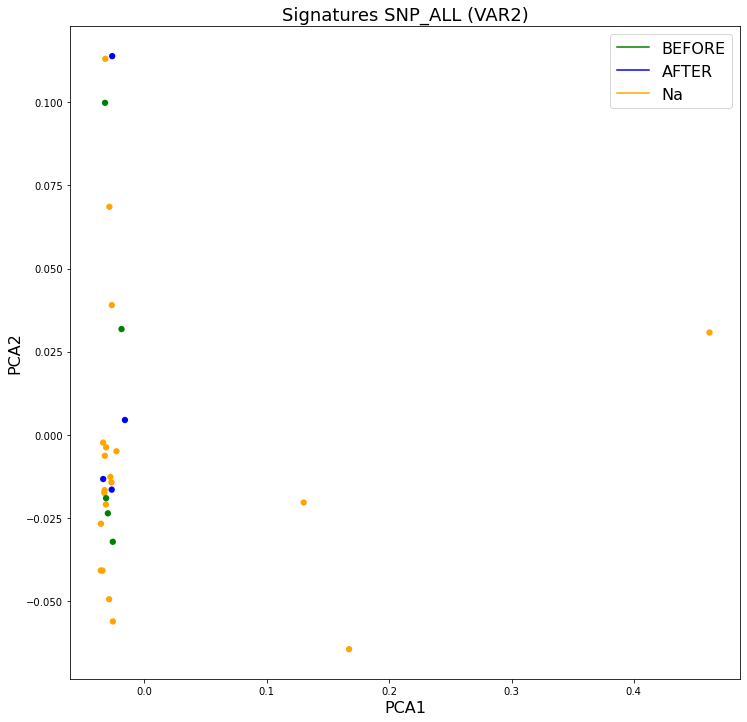

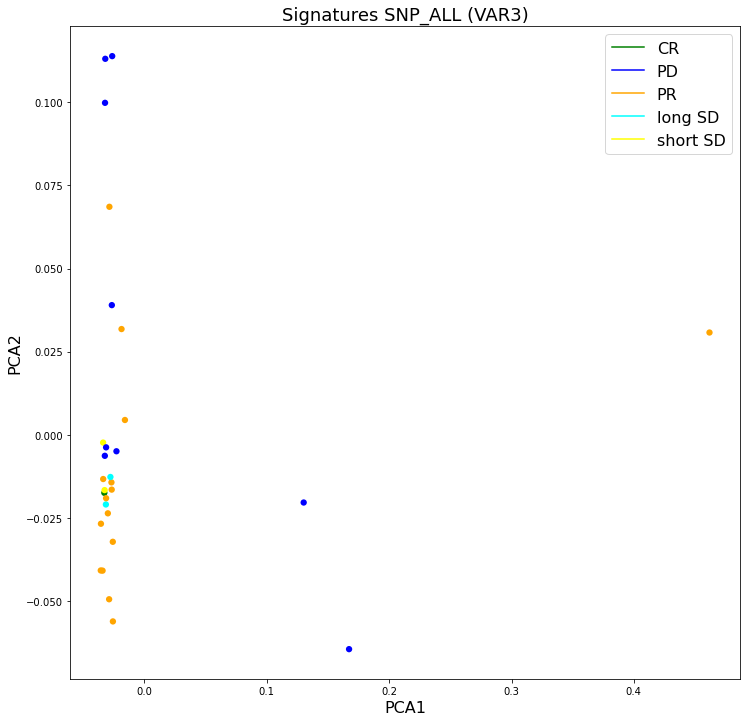

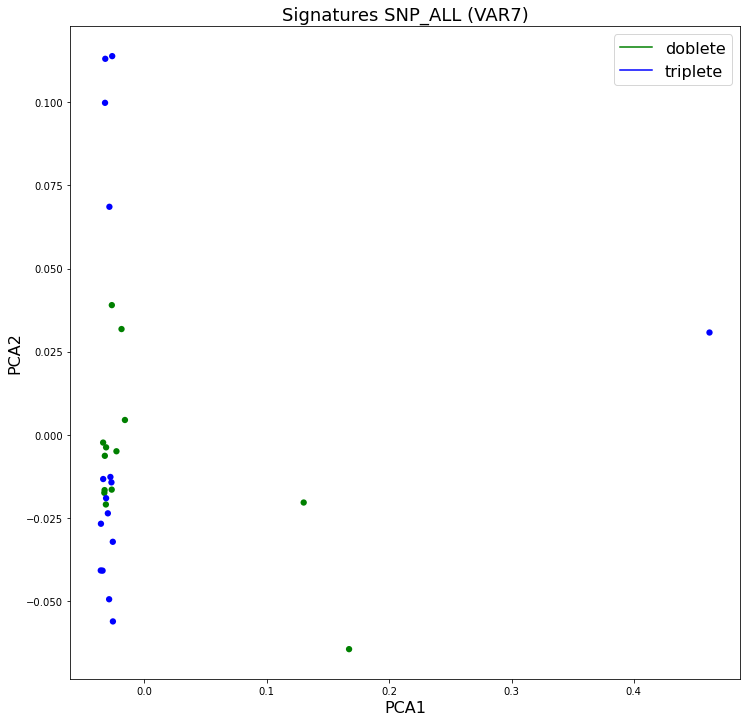

In [26]:
import signatureanalyzer as sa
from sklearn.preprocessing import StandardScaler

data = spectra_snv.copy()
results = sa.ardnmf(data, verbose=False)

data_norm = results['Hraw'].transpose() / results['Hraw'].sum(axis=1)

#data_norm = np.log1p(results['Hraw'].transpose())

#data_norm = results['Hraw'].transpose()

make_plots(data_norm, meta_filtered.reindex(data_norm.index), 'SNP_ALL')

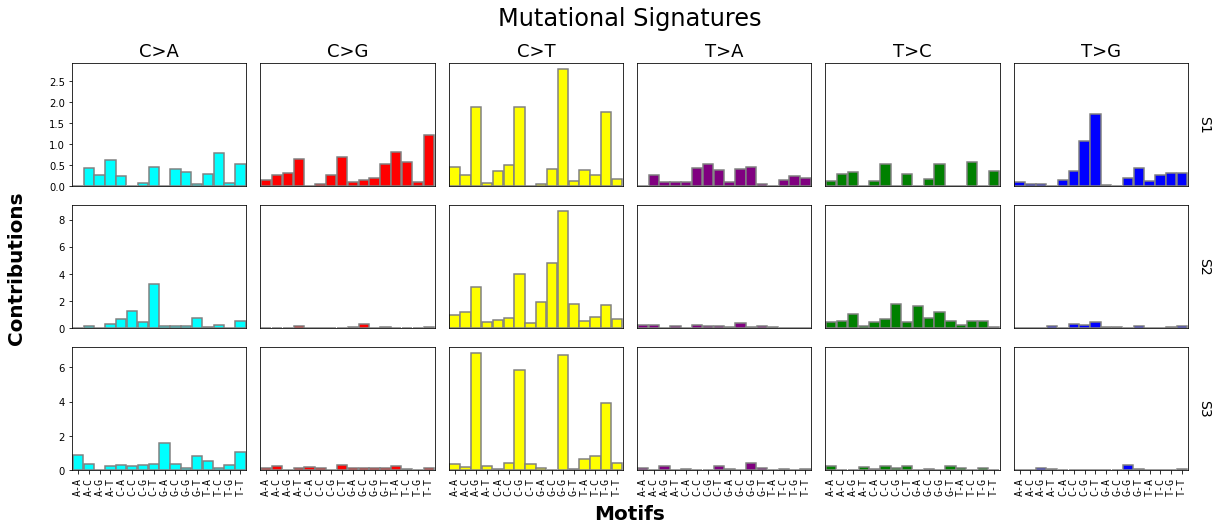

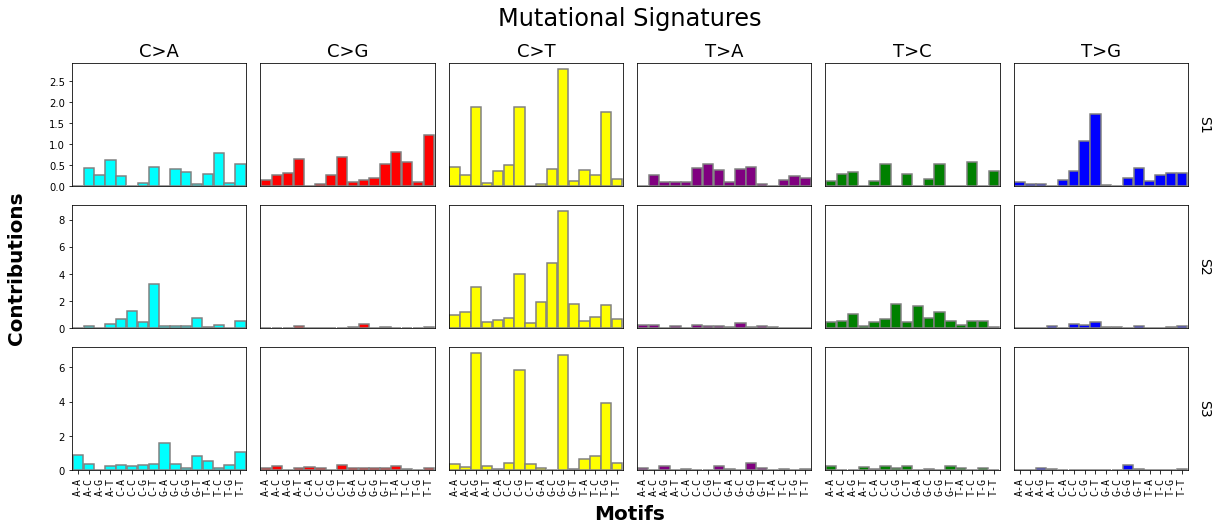

In [27]:
sa.pl.signature_barplot(results['Wraw'])

nit= 2064 K=3 	del=0.000000838


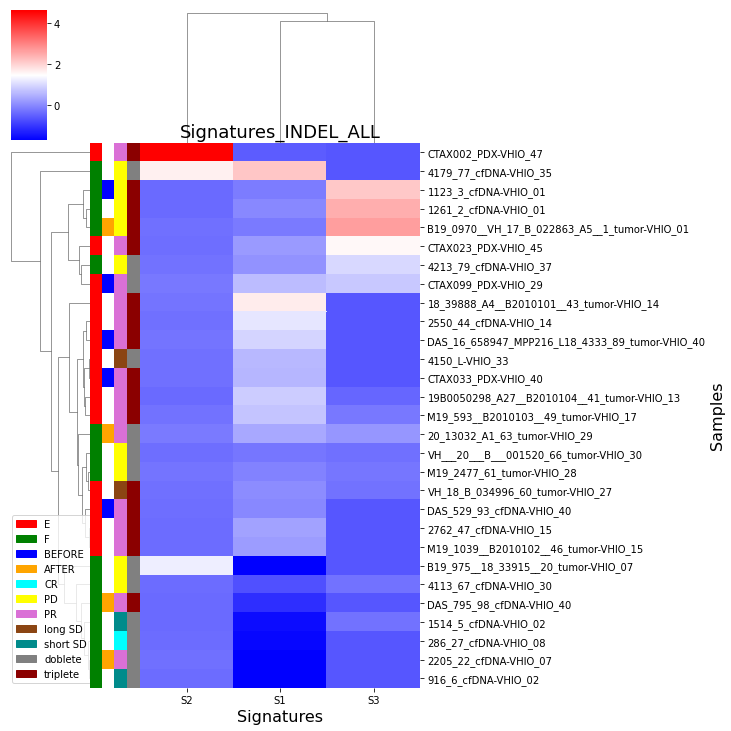

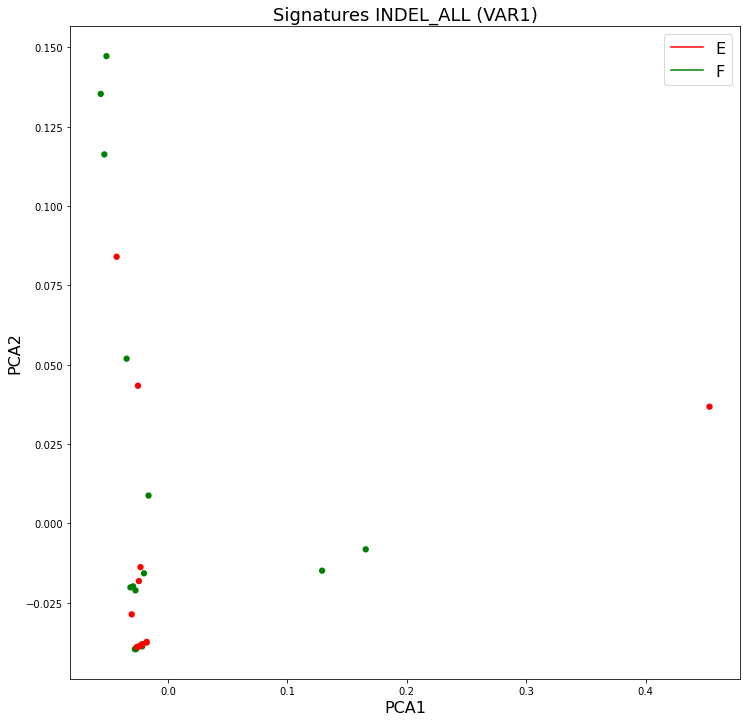

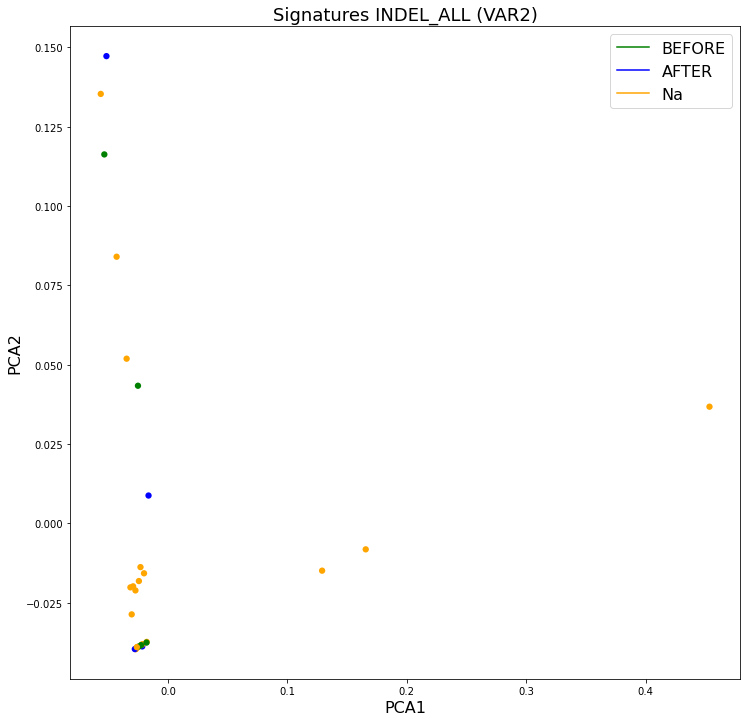

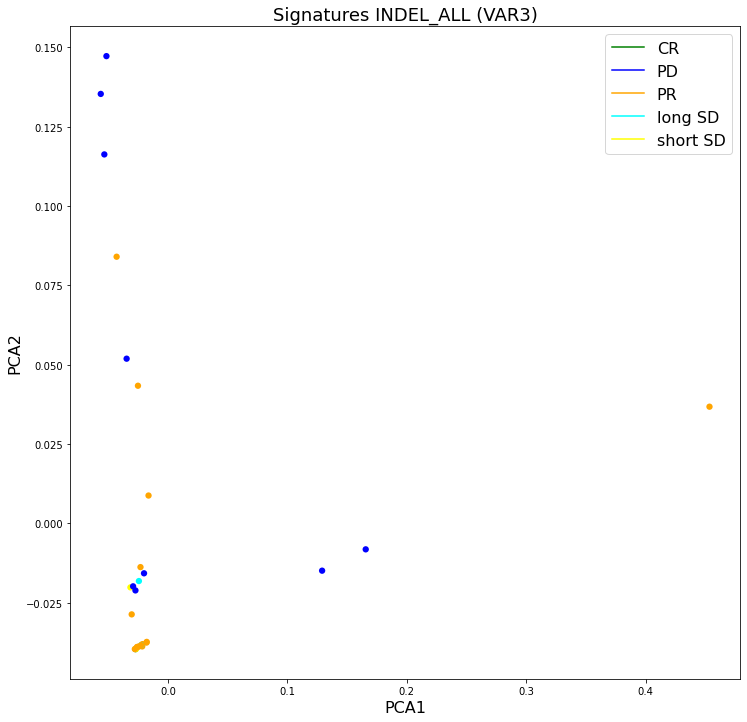

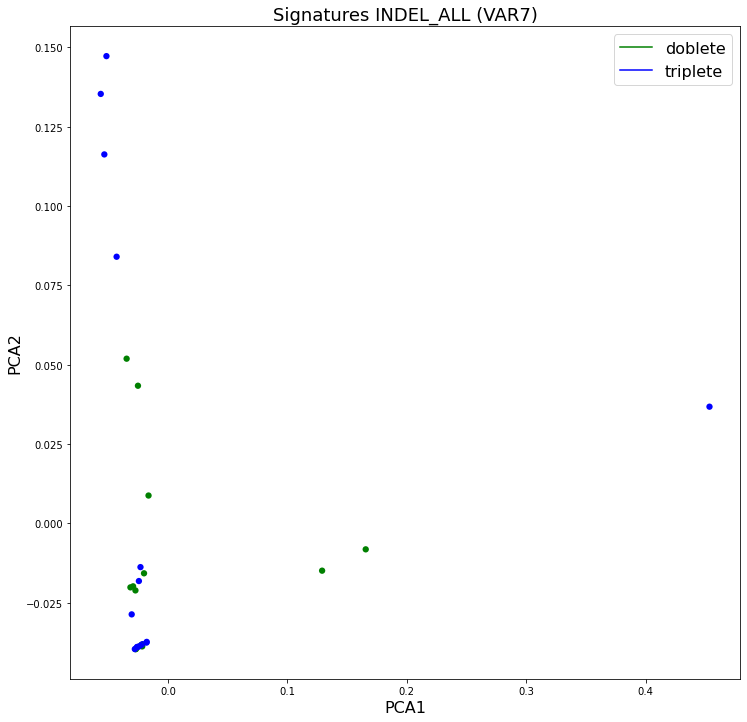

In [28]:
data = spectra_indels.copy()
results = sa.ardnmf(data, verbose=False)

data_norm = results['Hraw'].transpose() / results['Hraw'].sum(axis=1)

#data_norm = np.log1p(results['Hraw'].transpose())

#data_norm = results['Hraw'].transpose()

make_plots(data_norm, meta_filtered.reindex(data_norm.index), 'INDEL_ALL')

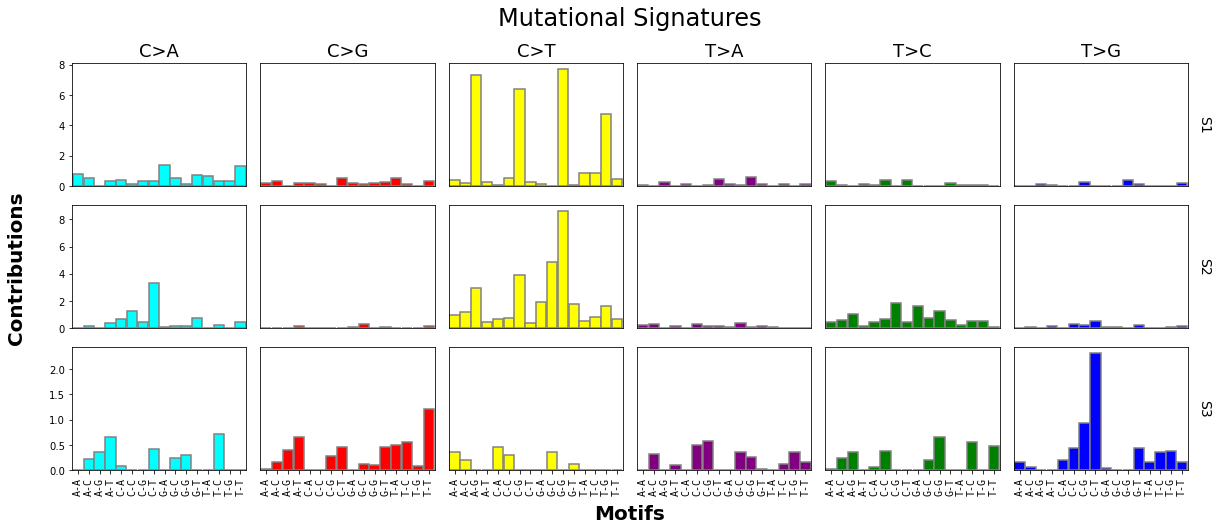

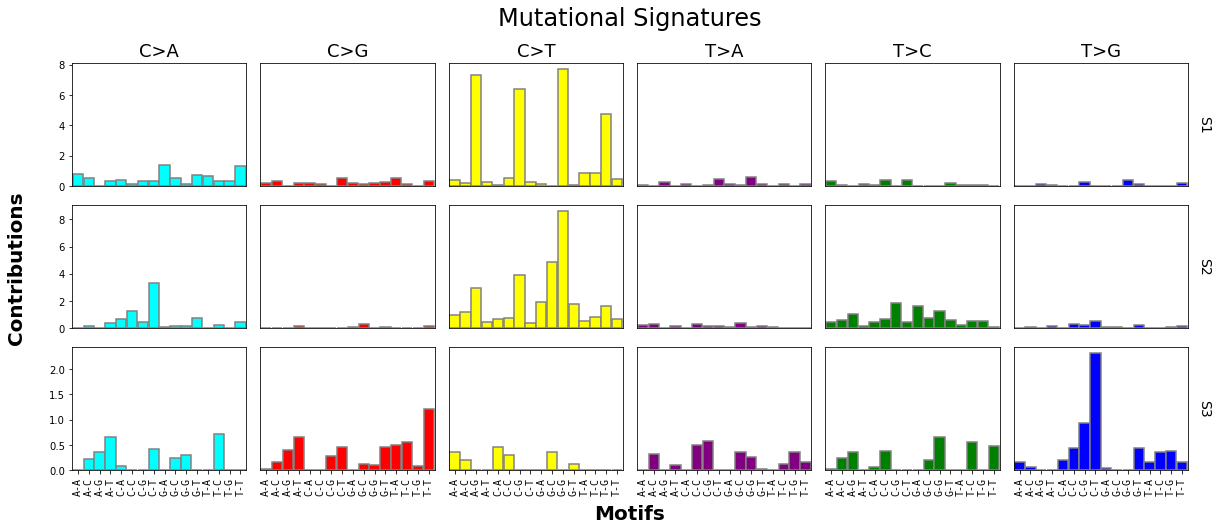

In [29]:
sa.pl.signature_barplot(results['Wraw'])

In [31]:
results['signatures']

,S1,S2,S3,max,max_id,max_norm,mean_on,mean_off,diff
context96.word,,,,,,,,,
CAGA,0.029383,0.002206,0.000000,0.029383,1,0.902660,3.190476,1.375000,1.815476
CAAA,0.016262,0.000000,0.000000,0.016262,1,1.000000,1.714286,0.375000,1.339286
CATA,0.014465,0.000963,0.000038,0.014465,1,0.912286,1.523810,0.750000,0.773810
ACCC,0.008446,0.000511,0.000000,0.008446,1,0.920102,0.904762,0.375000,0.529762
CATG,0.006845,0.000171,0.000000,0.006845,1,0.965359,0.666667,0.375000,0.291667
...,...,...,...,...,...,...,...,...,...
CGGC,0.002903,0.005215,0.006187,0.006187,3,0.645588,0.000000,1.037037,-1.037037
AGGT,0.001878,0.010045,0.011874,0.011874,3,0.774645,0.500000,1.629630,-1.129630
CTCC,0.011863,0.012954,0.014016,0.014016,3,0.560306,1.500000,2.851852,-1.351852
